## First model

In [2]:
import pandas as pd

from torch.utils.data import Dataset
from transformers import GPT2Tokenizer

from transformers import GPT2LMHeadModel
from transformers import get_linear_schedule_with_warmup

from torch.optim import AdamW

from transformers import get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import os
from pathlib import Path

Load our data

In [3]:
data_path = Path(os.getcwd()).parent / 'data'

df = pd.read_csv(f'{data_path}/lyrics_filtered_768tokens.csv')


print(f"Loaded {len(df):,} songs")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst row preview:")
print(df.iloc[0])

Loaded 39,415 songs

Columns: ['genre', 'lyrics', 'token_count', 'formatted_text']

First row preview:
genre                                                           Pop
lyrics            I feel so unsure\nAs I take your hand and lead...
token_count                                                     400
formatted_text    Genre: Pop\n\nI feel so unsure\nAs I take your...
Name: 0, dtype: object


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
print(device)
model_name = 'gpt2'
model_save_path = Path(os.getcwd()).parent / 'models'

cuda


In [8]:
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

special_tokens = {'additional_special_tokens': ['[POP]', '[INDIE]', '[METAL]']}
tokenizer.add_special_tokens(special_tokens)

print(f"\nTokenizer loaded:")
print(f"Vocab size: {len(tokenizer):,}")
print(f"EOS token: '{tokenizer.eos_token}' (ID: {tokenizer.eos_token_id})")
print(f"PAD token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")
print(f"Special tokens: {special_tokens['additional_special_tokens']}")


Tokenizer loaded:
Vocab size: 50,260
EOS token: '<|endoftext|>' (ID: 50256)
PAD token: '<|endoftext|>' (ID: 50256)
Special tokens: ['[POP]', '[INDIE]', '[METAL]']


### Custom dataset

In [14]:
class LyricsDataset(Dataset):
    
    def __init__(self, formatted_texts, tokenizer, max_length=768):

        self.input_ids = []
        self.attn_masks = []
        
        print(f"Pre-tokenizing {len(formatted_texts)} songs...")
        for text in tqdm(formatted_texts):
            encodings = tokenizer.encode_plus(
                text,
                truncation=True,
                padding='max_length',
                max_length=max_length,
                return_tensors='pt',
                add_special_tokens=True 
            )
            self.input_ids.append(encodings['input_ids'].squeeze(0))
            self.attn_masks.append(encodings['attention_mask'].squeeze(0))
        
        print("Tokenization complete")
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_masks[idx],
            'labels': self.input_ids[idx]
        }


## Initialise the data

In [15]:

train_df, temp_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['genre'],
    random_state=6
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.1,
    stratify=temp_df['genre'],
    random_state=6
)
# Preprocess the dataset to add special tokens
def preprocess_lyrics(df):
    def add_genre_token(row):
        genre_token = f"[{row['genre'].upper()}]"
        return f"{genre_token} {row['lyrics']}"  # Prepend token to lyrics
    df['formatted_text'] = df.apply(add_genre_token, axis=1)
    return df

# Apply preprocessing to train, val, and test splits
train_df = preprocess_lyrics(train_df)
val_df = preprocess_lyrics(val_df)
test_df = preprocess_lyrics(test_df)
print(train_df.head(1))
# Verify genre distribution
print(f"Genre distribution:\n{train_df['genre'].value_counts()}")

# Create datasets
train_dataset = LyricsDataset(train_df['formatted_text'].tolist(), tokenizer, max_length=768)
val_dataset = LyricsDataset(val_df['formatted_text'].tolist(), tokenizer, max_length=768)
test_dataset = LyricsDataset(test_df['formatted_text'].tolist(), tokenizer, max_length=768)

print(f"Dataset size: {len(train_dataset)}")
sample = train_dataset[0]
print(f"Sample shapes:")
print(f"  input_ids: {sample['input_ids'].shape}")
print(f"  attention_mask: {sample['attention_mask'].shape}")

      genre                                             lyrics  token_count  \
31633   Pop  Living inside my head pulling my strings\nLett...          353   

                                          formatted_text  
31633  [POP] Living inside my head pulling my strings...  
Genre distribution:
genre
Heavy Metal    10702
Pop            10503
Indie          10327
Name: count, dtype: int64
Pre-tokenizing 31532 songs...


  0%|          | 0/31532 [00:00<?, ?it/s]

Tokenization complete
Pre-tokenizing 7094 songs...


  0%|          | 0/7094 [00:00<?, ?it/s]

Tokenization complete
Pre-tokenizing 789 songs...


  0%|          | 0/789 [00:00<?, ?it/s]

Tokenization complete
Dataset size: 31532
Sample shapes:
  input_ids: torch.Size([768])
  attention_mask: torch.Size([768])


In [16]:
print(f"Dataset size: {len(train_dataset)}")
sample = train_dataset[0]
print(f"Sample shapes:")
print(f"  input_ids: {sample['input_ids'].shape}")
print(f"  attention_mask: {sample['attention_mask'].shape}")

Dataset size: 31532
Sample shapes:
  input_ids: torch.Size([768])
  attention_mask: torch.Size([768])


### Train LOOP

In [19]:

def train_loop(model, optimizer, scheduler, train_loader, device, epoch, num_epochs):
    model.train()
    epoch_train_loss = 0
    batch_losses = []
    learning_rates = []
    print(f"Starting training epoch {epoch+1}/{num_epochs} with {len(train_loader)} batches")
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)")
    for batch in progress_bar:
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=input_ids
                )
                loss = outputs.loss

                batch_losses.append(loss)
                learning_rates.append(scheduler.get_last_lr()[0])
                epoch_train_loss += loss.item()

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                scheduler.step()

                progress_bar.set_postfix({'train_loss': loss.item()})
                progress_bar.refresh()
            
            except RuntimeError as e:
                print(f"Error in training batch: {e}")
                raise
   
    return batch_losses, learning_rates

def validation_loop(model, val_loader, device, epoch, num_epochs):
        model.eval()
        batch_losses = []
        progress_bar =  tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)")
        with torch.no_grad():
            for batch in progress_bar:
                try:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=input_ids
                    )
                    batch_losses.append(outputs.loss.item())
                
                except RuntimeError as e:
                    print(f"Error in validation batch: {e}")
                    raise

        return batch_losses

def train_gpt2_model(
    model,
    train_loader,
    val_loader,
    device,
    optimizer,
    scheduler,
    num_epochs=3,
    patience=2,
    model_name="last_training"
    ):
    os.makedirs("./models", exist_ok=True)
    print('Using:', device)
    model = model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    history = {
        'train_loss_per_epoch': [],
        'val_loss_per_epoch': [],
        'train_loss_per_batch': [],
        'val_loss_per_batch': [],
        'learning_rates': [],
    }

    # Training loop
    for epoch in range(num_epochs):
        # Train
        epoch_train_losses, lrs = train_loop(model, optimizer, scheduler, train_loader, device, epoch, num_epochs)

        history['train_loss_per_batch'].extend(epoch_train_losses)
        history['learning_rates'].extend(lrs)
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        print(f"Epoch {epoch + 1}/{num_epochs} - Avg Training Loss: {avg_train_loss:.4f}")
        history['train_loss_per_epoch'].append(avg_train_loss)

        # Val
        epoch_val_losses = validation_loop(model, val_loader, device, epoch, num_epochs)
        history['val_loss_per_batch'].extend(epoch_val_losses)
        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        history['val_loss_per_epoch'].append(avg_val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}: Avg Validation Loss: {avg_val_loss:.4f}")


        if avg_val_loss < best_val_loss - 0.01:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"./models/{model_name}.pt")
            print(f'Saved best model checkpoint: epoch {epoch + 1}')
        else:
            patience_counter += 1
            print(f"Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping triggered after epoch {epoch + 1}")
                break

    print("Done!")            
    return model, history
    

### Test with small dataset

In [27]:
# get 10 procent of the data
small_df, _ = train_test_split(
    df,
    train_size=0.1,
    stratify=df['genre'],
    random_state=6
)
print(f"Genre distribution:\n{small_df['genre'].value_counts()}")
BATCH_SIZE = 4
MAX_LENGTH = 512

small_train_df, small_val_df = train_test_split(
    small_df, 
    test_size=0.2, 
    stratify=small_df['genre'],
    random_state=6
)
small_train_dataset = LyricsDataset(small_train_df['formatted_text'].tolist(), tokenizer, MAX_LENGTH)
small_val_dataset = LyricsDataset(small_val_df['formatted_text'].tolist(), tokenizer, MAX_LENGTH)

small_train_loader = DataLoader(
    small_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=False
)

small_val_loader = DataLoader(
    small_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=False
)
LEARNING_RATE = 3e-5
NUM_EPOCHS = 2
WARMUP_STEPS = 500
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

small_model = GPT2LMHeadModel.from_pretrained(model_name)
model = small_model.to(device)

optimizer = AdamW(small_model.parameters(), lr=LEARNING_RATE, weight_decay= WEIGHT_DECAY)

total_steps = len(small_train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)
print(f"\n{'='*60}")
print("TRAINING CONFIGURATION")
print(f"{'='*60}")
print(f"Model: {model_name}")
print(f"Device: {device}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max length: {MAX_LENGTH}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Total steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")
print(f"{'='*60}")


Genre distribution:
genre
Heavy Metal    1337
Pop            1313
Indie          1291
Name: count, dtype: int64
Pre-tokenizing 3152 songs...


  0%|          | 0/3152 [00:00<?, ?it/s]

Tokenization complete
Pre-tokenizing 789 songs...


  0%|          | 0/789 [00:00<?, ?it/s]

Tokenization complete

TRAINING CONFIGURATION
Model: distilgpt2
Device: cuda
Batch size: 4
Max length: 512
Learning rate: 3e-05
Epochs: 2
Total steps: 1576
Warmup steps: 157


In [28]:
small_model, history = train_gpt2_model(small_model, small_train_loader, small_val_loader, device, optimizer, scheduler, num_epochs=NUM_EPOCHS)

Using: cuda
Starting training epoch 1/2 with 788 batches


Epoch 1/2 (Training):   0%|          | 0/788 [00:00<?, ?it/s]

Epoch 1/2 - Avg Training Loss: 2.0262


Epoch 1/2 (Validation):   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 1/2: Avg Validation Loss: 1.4825
Saved best model checkpoint: epoch 1
Starting training epoch 2/2 with 788 batches


Epoch 2/2 (Training):   0%|          | 0/788 [00:00<?, ?it/s]

Epoch 2/2 - Avg Training Loss: 1.5398


Epoch 2/2 (Validation):   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 2/2: Avg Validation Loss: 1.4713
Saved best model checkpoint: epoch 2
Done!


 ### Big TF

In [ ]:

model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer)) 
model = model.to(device)

# DataLoader setup
BATCH_SIZE = 8  # Increased for faster training, adjust based on GPU memory
MAX_LENGTH = 512  # Keep as is, or reduce if memory is an issue
LEARNING_RATE = 3e-5
NUM_EPOCHS = 5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Training configuration summary
print(f"\n{'='*60}")
print("TRAINING CONFIGURATION")
print(f"{'='*60}")
print(f"Model: {model_name}")
print(f"Device: {device}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max length: {MAX_LENGTH}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Total steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")
print(f"{'='*60}")

Train batches: 3942
Val batches: 887

TRAINING CONFIGURATION
Model: gpt2
Device: cuda
Batch size: 8
Max length: 512
Learning rate: 3e-05
Epochs: 5
Total steps: 19710
Warmup steps: 1971


In [20]:
model, history = train_gpt2_model(
    model,
    train_loader,
    val_loader,
    device,
    optimizer,
    scheduler,
    num_epochs=NUM_EPOCHS,
    patience=2,
    model_name="finetuned_distilgpt2_with_tokens"
)

Using: cuda
Starting training epoch 1/5 with 3942 batches


Epoch 1/5 (Training):   0%|          | 0/3942 [00:00<?, ?it/s]

Epoch 1/5 - Avg Training Loss: 2.7971


Epoch 1/5 (Validation):   0%|          | 0/887 [00:00<?, ?it/s]

Epoch 1/5: Avg Validation Loss: 0.9363
Saved best model checkpoint: epoch 1
Starting training epoch 2/5 with 3942 batches


Epoch 2/5 (Training):   0%|          | 0/3942 [00:00<?, ?it/s]

Epoch 2/5 - Avg Training Loss: 0.9383


Epoch 2/5 (Validation):   0%|          | 0/887 [00:00<?, ?it/s]

Epoch 2/5: Avg Validation Loss: 0.9223
Saved best model checkpoint: epoch 2
Starting training epoch 3/5 with 3942 batches


Epoch 3/5 (Training):   0%|          | 0/3942 [00:00<?, ?it/s]

Epoch 3/5 - Avg Training Loss: 0.9176


Epoch 3/5 (Validation):   0%|          | 0/887 [00:00<?, ?it/s]

Epoch 3/5: Avg Validation Loss: 0.9165
Patience counter: 1/2
Starting training epoch 4/5 with 3942 batches


Epoch 4/5 (Training):   0%|          | 0/3942 [00:00<?, ?it/s]

Epoch 4/5 - Avg Training Loss: 0.9049


Epoch 4/5 (Validation):   0%|          | 0/887 [00:00<?, ?it/s]

Epoch 4/5: Avg Validation Loss: 0.9132
Patience counter: 2/2
Early stopping triggered after epoch 4
Done!


In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt

def to_cpu_floats(lst):
    return [x.detach().cpu().item() if hasattr(x, "detach") else float(x) for x in lst]

def smooth_array(x, window=50):
    if window <= 1:
        return np.array(x)
    smoothed = []
    for i in range(len(x)):
        start = max(0, i - window // 2)
        end = min(len(x), i + window // 2)
        smoothed.append(np.mean(x[start:end]))
    return np.array(smoothed)

def create_poster_plots(history, num_epochs=None, batches_per_epoch=None, save_dir='./plots'):
    """Two poster plots: batch-level (with val) + epoch-level (with perplexity)."""
    os.makedirs(save_dir, exist_ok=True)

    # --- Convert tensors safely ---
    for k, v in history.items():
        if isinstance(v, list):
            history[k] = to_cpu_floats(v)

    train_batch = np.array(history['train_loss_per_batch'])
    val_batch   = np.array(history['val_loss_per_batch'])
    train_epoch = np.array(history['train_loss_per_epoch'])
    val_epoch   = np.array(history['val_loss_per_epoch'])
    lrs         = np.array(history.get('learning_rates', []))

    # PLOT 1
    fig, ax1 = plt.subplots(figsize=(10, 5))

    steps = np.arange(len(train_batch))
    smooth_window = max(10, len(train_batch)//200)
    smooth_train = smooth_array(train_batch, window=smooth_window)

    ax1.plot(steps, smooth_train, color='#0072B2', linewidth=2.5, label='Train Loss (Smoothed)')

    # 
    if len(val_batch) > 0:
        val_steps = np.linspace(0, len(train_batch), len(val_batch))
        smooth_val = smooth_array(val_batch, window=smooth_window)
        ax1.plot(val_steps, smooth_val, color='#D55E00', linewidth=2.0, label='Val Loss (Smoothed)')

    ax1.set_xlabel('Training Step (batches)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Highlight epoch boundaries
    if num_epochs and batches_per_epoch:
        for e in range(1, num_epochs):
            step = e * batches_per_epoch
            ax1.axvline(step, color='gray', linestyle='--', alpha=0.3)
            ax1.text(step, ax1.get_ylim()[1]*0.95, f'E{e}', ha='center', color='gray', fontsize=9)

    # 
    if len(lrs) == len(train_batch):
        ax2 = ax1.twinx()
        ax2.plot(steps, lrs, color='gray', linestyle='--', alpha=0.6, label='Learning Rate')
        ax2.set_ylabel('Learning Rate', color='gray', fontsize=11)
        ax2.tick_params(axis='y', colors='gray')
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=11)
    else:
        ax1.legend(fontsize=11, loc='upper right')

    plt.title('Batch-level Training and Validation Dynamics', fontsize=16, fontweight='bold', pad=10)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/poster_batch_loss.png', dpi=400, bbox_inches='tight')
    plt.show()

    # ==================== PLOT 2: Epoch-level (Loss + Perplexity) ====================
    fig, ax = plt.subplots(figsize=(8, 5))
    epochs = np.arange(1, len(train_epoch) + 1)

    # Base loss curves
    ax.plot(epochs, train_epoch, '-o', color='#0072B2', linewidth=2.5, label='Train Loss')
    ax.plot(epochs, val_epoch, '-s', color='#D55E00', linewidth=2.5, label='Validation Loss')

    if len(train_epoch) == len(val_epoch):
        ax.fill_between(epochs, train_epoch, val_epoch, color='orange', alpha=0.15, label='Generalization Gap')

    ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11, loc='upper right', frameon=False)
    ax.set_title('Train vs Validation: Loss and Perplexity', fontsize=16, fontweight='bold', pad=10)

    # ---- Secondary Perplexity Axis (visible dashed curves) ----
    '''
     ax2 = ax.twinx()
    train_ppl = np.exp(train_epoch)
    val_ppl   = np.exp(val_epoch)

    ax2.plot(epochs, train_ppl, '--', color='#0072B2', alpha=0.6, linewidth=2, label='Train PPL')
    ax2.plot(epochs, val_ppl, '--', color='#D55E00', alpha=0.6, linewidth=2, label='Val PPL')

    ax2.set_ylabel('Perplexity', fontsize=13, color='gray', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Merge legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11, frameon=False)
    '''
   

    plt.tight_layout()
    plt.savefig(f'{save_dir}/poster_epoch_loss_ppl.png', dpi=400, bbox_inches='tight')
    plt.show()

    print("✓ Saved poster plots with train+val batch curves and perplexity:", save_dir)


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt

def to_cpu_floats(lst):
    return [x.detach().cpu().item() if hasattr(x, "detach") else float(x) for x in lst]

def smooth_array(x, window=50):
    if window <= 1:
        return np.array(x)
    smoothed = []
    for i in range(len(x)):
        start = max(0, i - window // 2)
        end = min(len(x), i + window // 2)
        smoothed.append(np.mean(x[start:end]))
    return np.array(smoothed)

def create_poster_plots(history, num_epochs=None, batches_per_epoch=None, save_dir='./plots'):
    """Two poster plots: batch-level (with val) + epoch-level (with perplexity)."""
    os.makedirs(save_dir, exist_ok=True)

    # --- Convert tensors safely ---
    for k, v in history.items():
        if isinstance(v, list):
            history[k] = to_cpu_floats(v)

    train_batch = np.array(history['train_loss_per_batch'])
    val_batch   = np.array(history['val_loss_per_batch'])
    train_epoch = np.array(history['train_loss_per_epoch'])
    val_epoch   = np.array(history['val_loss_per_epoch'])
    lrs         = np.array(history.get('learning_rates', []))

    # PLOT 1
    fig, ax1 = plt.subplots(figsize=(10, 5))

    steps = np.arange(len(train_batch))
    smooth_window = max(10, len(train_batch)//200)
    smooth_train = smooth_array(train_batch, window=smooth_window)

    ax1.plot(steps, smooth_train, color='#0072B2', linewidth=2.5, label='Train Loss (Smoothed)')

    # 
    if len(val_batch) > 0:
        val_steps = np.linspace(0, len(train_batch), len(val_batch))
        smooth_val = smooth_array(val_batch, window=smooth_window)
        ax1.plot(val_steps, smooth_val, color='#D55E00', linewidth=2.0, label='Val Loss (Smoothed)')

    ax1.set_xlabel('Training Step (batches)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Highlight epoch boundaries
    if num_epochs and batches_per_epoch:
        for e in range(1, num_epochs):
            step = e * batches_per_epoch
            ax1.axvline(step, color='gray', linestyle='--', alpha=0.3)
            ax1.text(step, ax1.get_ylim()[1]*0.95, f'E{e}', ha='center', color='gray', fontsize=9)

    # 
    if len(lrs) == len(train_batch):
        ax2 = ax1.twinx()
        ax2.plot(steps, lrs, color='gray', linestyle='--', alpha=0.6, label='Learning Rate')
        ax2.set_ylabel('Learning Rate', color='gray', fontsize=11)
        ax2.tick_params(axis='y', colors='gray')
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=11)
    else:
        ax1.legend(fontsize=11, loc='upper right')

    plt.title('Batch-level Training and Validation Dynamics', fontsize=16, fontweight='bold', pad=10)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/poster_batch_loss.png', dpi=400, bbox_inches='tight')
    plt.show()

    # ==================== PLOT 2: Epoch-level (Loss + Perplexity) ====================
    fig, ax = plt.subplots(figsize=(8, 5))
    epochs = np.arange(1, len(train_epoch) + 1)

    # Base loss curves
    ax.plot(epochs, train_epoch, '-o', color='#0072B2', linewidth=2.5, label='Train Loss')
    ax.plot(epochs, val_epoch, '-s', color='#D55E00', linewidth=2.5, label='Validation Loss')

    if len(train_epoch) == len(val_epoch):
        ax.fill_between(epochs, train_epoch, val_epoch, color='orange', alpha=0.15, label='Generalization Gap')

    ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11, loc='upper left', frameon=False)
    ax.set_title('Train vs Validation: Loss and Perplexity', fontsize=16, fontweight='bold', pad=10)

    # ---- Secondary Perplexity Axis (visible dashed curves) ----
    '''
    '''
   

    plt.tight_layout()
    plt.savefig(f'{save_dir}/poster_epoch_loss_ppl.png', dpi=400, bbox_inches='tight')
    plt.show()

    print("✓ Saved poster plots with train+val batch curves and perplexity:", save_dir)


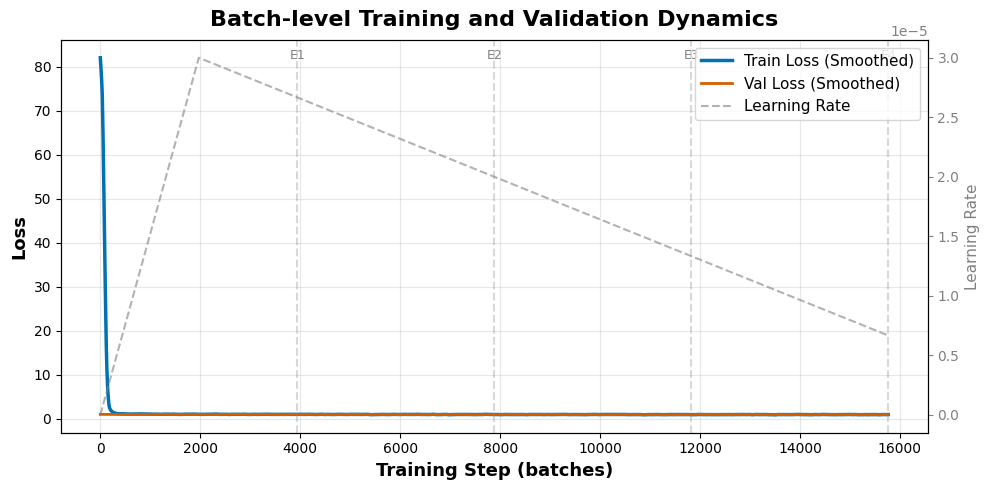

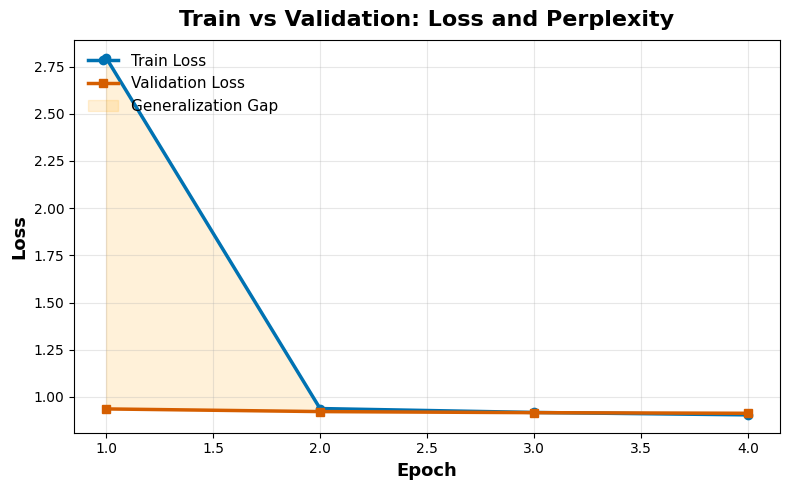

✓ Saved poster plots with train+val batch curves and perplexity: ./plots


In [22]:
create_poster_plots(history, num_epochs=NUM_EPOCHS, batches_per_epoch=len(train_loader))


In [ ]:

import json
os.makedirs("./params", exist_ok=True)
os.makedirs("./data", exist_ok=True)


for k, v in big_history.items():
    if isinstance(v, list):
        big_history[k] = [float(x.detach().cpu()) if hasattr(x, "detach") else float(x) for x in v]

history_path = "./params/big_training_history.json"
with open(history_path, "w") as f:
    json.dump(big_history, f, indent=2)

train_path = "./data/train_split.csv"
val_path   = "./data/val_split.csv"
test_path  = "./data/test_split.csv"

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)
